In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:39835")
client

<Client: 'tcp://127.0.0.1:39835' processes=8 threads=40, memory=157.36 GiB>

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import os.path as op
from fastjmd95 import drhods, drhodt 
import os
import gsw
from xhistogram.xarray import histogram as xhist
from xgcm.grid import Grid
from xmitgcm import open_mdsdataset
from fastjmd95 import rho as densjmd95
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ddir = '/tank/chaocean/qjamet/RUNS/ORAR/reruns2/'
gdir = '/tank/chaocean/grid_chaO/gridMIT_update1/'
savedir = '/tank/spectre/tuchida/chaocean/Snap/'

In [4]:
grav = 9.81
nensembs = 5
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
rhoConst = 9.998e2
# Cp = 3.994e3
Cp = 3989.244953
# years = np.arange(2008,2013,dtype=int)
ySstart = -15
yNstart = 15
yend = 50
dnf = 2160
nfile = 73

xchunk = 100
ychunk = 100

nmembs = np.arange(100,148)

In [5]:
years = np.arange(1967,1968,dtype=int)
ntimes = np.arange(1419120,1576800,dnf).reshape(len(years),nfile)
dd = 25  # 
yystart = 0
ntimes[yystart,8:]

array([1436400, 1438560, 1440720, 1442880, 1445040, 1447200, 1449360,
       1451520, 1453680, 1455840, 1458000, 1460160, 1462320, 1464480,
       1466640, 1468800, 1470960, 1473120, 1475280, 1477440, 1479600,
       1481760, 1483920, 1486080, 1488240, 1490400, 1492560, 1494720,
       1496880, 1499040, 1501200, 1503360, 1505520, 1507680, 1509840,
       1512000, 1514160, 1516320, 1518480, 1520640, 1522800, 1524960,
       1527120, 1529280, 1531440, 1533600, 1535760, 1537920, 1540080,
       1542240, 1544400, 1546560, 1548720, 1550880, 1553040, 1555200,
       1557360, 1559520, 1561680, 1563840, 1566000, 1568160, 1570320,
       1572480, 1574640])

In [6]:
dsg = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                              % (100)), 
                      grid_dir=gdir,
                      prefix=['snap_diagOcn'], delta_t=2e2,
                      iters=ntimes[0,0], 
                     ).chunk({'YC':ychunk,'YG':ychunk,
                              'XC':xchunk,'XG':xchunk})
grid = Grid(dsg, periodic=['X'])
dsg

<xarray.Dataset>
Dimensions:  (time: 1, XC: 1000, YC: 900, XG: 1000, YG: 900, Z: 46, Zp1: 47,
              Zu: 46, Zl: 46)
Coordinates: (12/33)
    iter     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time     (time) timedelta64[ns] 3285 days
  * XC       (XC) >f4 262.0 262.1 262.2 262.3 262.3 ... 347.7 347.8 347.9 348.0
  * YC       (YC) >f4 -19.92 -19.83 -19.75 -19.67 ... 54.75 54.83 54.92 55.0
  * XG       (XG) >f4 262.0 262.0 262.1 262.2 262.3 ... 347.7 347.8 347.8 347.9
  * YG       (YG) >f4 -19.96 -19.87 -19.79 -19.71 ... 54.71 54.79 54.88 54.96
    ...       ...
    maskW    (Z, YC, XG) bool dask.array<chunksize=(46, 100, 100), meta=np.ndarray>
    maskS    (Z, YG, XC) bool dask.array<chunksize=(46, 100, 100), meta=np.ndarray>
    maskInC  (YC, XC) bool dask.array<chunksize=(100, 100), meta=np.ndarray>
    rhoRef   (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>
    maskInW  (YC, XG) bool dask.array<chunksize=(100, 100), meta=np.ndarray>
    maskInS  (YG, XC) bool dask.array<chunksize=(100, 100), meta=np.ndarray>
Data variables:
    THETA    (time, Z, YC, XC) >f4 dask.array<chunksize=(1, 46, 100, 100), meta=np.ndarray>
    SALT     (time, Z, YC, XC) >f4 dask.array<chunksize=(1, 46, 100, 100), meta=np.ndarray>
    UVEL     (time, Z, YC, XG) >f4 dask.array<chunksize=(1, 46, 100, 100), meta=np.ndarray>
    VVEL     (time, Z, YG, XC) >f4 dask.array<chunksize=(1, 46, 100, 100), meta=np.ndarray>
    WVEL     (time, Zl, YC, XC) >f4 dask.array<chunksize=(1, 46, 100, 100), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir='/tank/chaocea...

In [9]:
for itime in ntimes[yystart,8:10]:
    dsm = open_mdsdataset(op.join(ddir,'ensm/run1967/ocn/'), 
                          grid_dir=gdir,
                          prefix=['snap_diagOcn'], delta_t=2e2,
                          iters=itime, 
                         ).chunk({'YC':ychunk,'YG':ychunk,
                                  'XC':xchunk,'XG':xchunk})
    # dsb = xr.open_zarr(op.join(chaos,'%04d/%010d/BUOY.zarr' 
    #                            % (years[0],itime))
    #                   )
    # dsbm = xr.open_zarr(op.join(chaos,'%04d/ensm/%010d/BUOY.zarr' 
    #                             % (years[0],itime))
    #                    )
    
    for nn in nmembs:
        if nn == 100:
            ds = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                         % (nn)), 
                                 grid_dir=gdir,
                                 prefix=['snap_diagOcn'], delta_t=2e2,
                                 iters=itime, 
                                ).chunk({'YC':ychunk,'YG':ychunk,
                                         'XC':xchunk,'XG':xchunk})
        else:
            ds = xr.concat([ds, open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                                        % (nn)), 
                                                grid_dir=gdir,
                                                prefix=['snap_diagOcn'], delta_t=2e2,
                                                iters=itime, 
                                               ).chunk({'YC':ychunk,'YG':ychunk,
                                                        'XC':xchunk,'XG':xchunk})
                           ], dim='nmemb')

    ds.coords['nmemb'] = ('nmemb',nmembs)
    
    alpha = xr.apply_ufunc(drhodt, dsm.SALT, dsm.THETA, np.abs(grav*ds.Z),
                           dask='parallelized')
    beta  = xr.apply_ufunc(drhods, dsm.SALT, dsm.THETA, np.abs(grav*ds.Z),
                           dask='parallelized')
    Tp = (ds.THETA - dsm.THETA).where(ds.maskC!=0.)
    Sp = (ds.SALT  -  dsm.SALT).where(ds.maskC!=0.)
    
    bp_t = (-alpha * grav/rhoConst) * Tp
    bp_s = (- beta * grav/rhoConst) * Sp
    
    # if itime == ntimes[yystart,0]:
    #     bp_r = (bp_t + bp_s)
    #     bp = (dsb.BUOY - dsbm.BUOY).where(ds.maskC!=0.)
    # else:
    #     bp_r = xr.concat([bp_r, (bp_t + bp_s)], 'time')
    #     bp = xr.concat([bp, (dsb.BUOY - dsbm.BUOY).where(ds.maskC!=0.)
    #                    ], 'time')
    bp_r = (bp_t + bp_s)
    dsave = bp_r.to_dataset(name='bp')
    dsave.to_zarr(op.join(savedir,'%4d/%010d/Eddy/BUOY_recon.zarr' 
                          % (years[yystart],itime)), mode='w')
    dsave.close()
    dsm.close()
    # dsbm.close()
    # dsb.close()
    ds.close()
    print(itime)
bp_r

1436400
1438560


<xarray.DataArray (time: 1, Z: 46, YC: 900, XC: 1000, nmemb: 48)>
dask.array<add, shape=(1, 46, 900, 1000, 48), dtype=float64, chunksize=(1, 46, 100, 100, 1), chunktype=numpy.ndarray>
Coordinates: (12/14)
    iter     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time     (time) timedelta64[ns] 3330 days
  * XC       (XC) >f4 262.0 262.1 262.2 262.3 262.3 ... 347.7 347.8 347.9 348.0
  * YC       (YC) >f4 -19.92 -19.83 -19.75 -19.67 ... 54.75 54.83 54.92 55.0
  * Z        (Z) >f4 -3.047 -9.454 -16.36 ... -5.375e+03 -5.625e+03 -5.875e+03
    rA       (YC, XC) >f4 dask.array<chunksize=(100, 100), meta=np.ndarray>
    ...       ...
    PHrefC   (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>
    hFacC    (Z, YC, XC) >f4 dask.array<chunksize=(46, 100, 100), meta=np.ndarray>
    maskC    (Z, YC, XC) bool dask.array<chunksize=(46, 100, 100), meta=np.ndarray>
    maskInC  (YC, XC) bool dask.array<chunksize=(100, 100), meta=np.ndarray>
    rhoRef   (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>
  * nmemb    (nmemb) int64 100 101 102 103 104 105 ... 142 143 144 145 146 147

In [7]:
for itime in ntimes[yystart,:]:
    dsb = xr.open_zarr(op.join(savedir,'%04d/%010d/BUOY.zarr' 
                               % (years[0],itime))
                      )
    dsbm = xr.open_zarr(op.join(savedir,'%04d/ensm/%010d/BUOY.zarr' 
                                % (years[0],itime))
                       )
    dsr = xr.open_zarr(op.join(savedir,'%4d/%010d/Eddy/BUOY_recon.zarr' 
                               % (years[yystart],itime))
                      )
    if itime == ntimes[yystart,0]:
        bp_r = dsr.bp
        bp = (dsb.BUOY - dsbm.BUOY).where(dsg.maskC!=0.)
    else:
        bp_r = xr.concat([bp_r, dsr.bp], 'time')
        bp = xr.concat([bp, (dsb.BUOY - dsbm.BUOY).where(dsg.maskC!=0.)
                       ], 'time')
    dsb.close()
    dsbm.close()
    dsr.close()
    print(itime)
bp_r

1419120
1421280
1423440
1425600
1427760
1429920
1432080
1434240
1436400
1438560
1440720
1442880
1445040
1447200
1449360
1451520
1453680
1455840
1458000
1460160
1462320
1464480
1466640
1468800
1470960
1473120
1475280
1477440
1479600
1481760
1483920
1486080
1488240
1490400
1492560
1494720
1496880
1499040
1501200
1503360
1505520
1507680
1509840
1512000
1514160
1516320
1518480
1520640
1522800
1524960
1527120
1529280
1531440
1533600
1535760
1537920
1540080
1542240
1544400
1546560
1548720
1550880
1553040
1555200
1557360
1559520
1561680
1563840
1566000
1568160
1570320
1572480
1574640


<xarray.DataArray 'bp' (time: 73, Z: 46, YC: 900, XC: 1000, nmemb: 48)>
dask.array<concatenate, shape=(73, 46, 900, 1000, 48), dtype=float64, chunksize=(1, 46, 100, 100, 1), chunktype=numpy.ndarray>
Coordinates: (12/14)
    Depth    (YC, XC) float32 3.441e+03 3.215e+03 ... 2.917e+03 2.824e+03
    PHrefC   (Z) float32 29.89 92.74 160.5 ... 5.273e+04 5.518e+04 5.764e+04
  * XC       (XC) float32 262.0 262.1 262.2 262.3 ... 347.7 347.8 347.9 348.0
  * YC       (YC) float32 -19.92 -19.83 -19.75 -19.67 ... 54.75 54.83 54.92 55.0
  * Z        (Z) float32 -3.047 -9.454 -16.36 ... -5.625e+03 -5.875e+03
    drF      (Z) float32 6.094 6.721 7.099 7.971 ... 248.9 249.6 249.9 250.5
    ...       ...
    maskC    (Z, YC, XC) bool True True True True ... False False False False
    maskInC  (YC, XC) bool False False False False ... False False False False
  * nmemb    (nmemb) int64 100 101 102 103 104 105 ... 142 143 144 145 146 147
    rA       (YC, XC) float32 8.334e+07 8.334e+07 ... 5.084e+07 5.084e+07
    rhoRef   (Z) float32 1.021e+03 1.021e+03 1.021e+03 ... 1.044e+03 1.044e+03
  * time     (time) timedelta64[ns] 3285 days 3290 days ... 3640 days 3645 days

## $$b' \simeq b_{\langle\Theta\rangle} \Theta' + b_{\langle S\rangle} S'$$

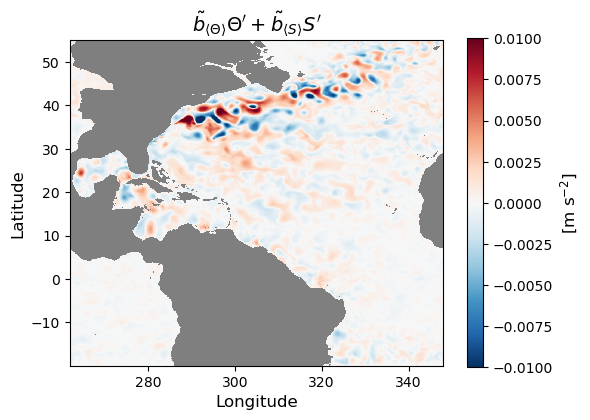

In [8]:
fig, ax = plt.subplots(figsize=(6,5))
fig.set_tight_layout(True)

im = ax.pcolormesh(bp_r.XC, bp_r.YC, bp_r.isel(time=0,nmemb=0,Z=15),
              vmin=-1e-2, vmax=1e-2, cmap='RdBu_r', rasterized=True)
ax.pcolormesh(dsg.XC, dsg.YC, dsg.maskC.where(dsg.maskC!=1.).isel(Z=15),
              vmin=-2, vmax=2, cmap='binary', rasterized=True)

ax.set_title(r"$\tilde{b}_{\langle\Theta\rangle}\Theta'+\tilde{b}_{\langle S\rangle}S'$", 
             fontsize=14)
ax.set_ylabel(r"Latitude", fontsize=12)
ax.set_xlabel(r"Longitude", fontsize=12)
ax.set_aspect('equal')

cbar = fig.colorbar(im, ax=ax, shrink=.7)
cbar.set_label(r"[m s$^{-2}$]", fontsize=12)
plt.savefig(op.join(savedir,'Figures/bp_recon_%010d.pdf' % ntimes[0,0]))

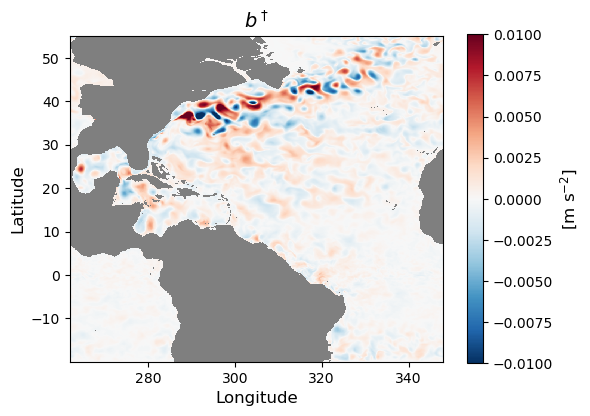

In [9]:
fig, ax = plt.subplots(figsize=(6,5))
fig.set_tight_layout(True)

im = ax.pcolormesh(bp.XC, bp.YC, bp.isel(time=0,nmemb=0,Z=15),
              vmin=-1e-2, vmax=1e-2, cmap='RdBu_r', rasterized=True)
ax.pcolormesh(dsg.XC, dsg.YC, dsg.maskC.where(dsg.maskC!=1.).isel(Z=15),
              vmin=-2, vmax=2, cmap='binary', rasterized=True)

ax.set_title(r"$b^\dagger$", fontsize=14)
ax.set_ylabel(r"Latitude", fontsize=12)
ax.set_xlabel(r"Longitude", fontsize=12)
ax.set_aspect('equal')

cbar = fig.colorbar(im, ax=ax, shrink=.7)
cbar.set_label(r"[m s$^{-2}$]", fontsize=12)
plt.savefig(op.join(savedir,'Figures/bp_%010d.pdf' % ntimes[0,0]))

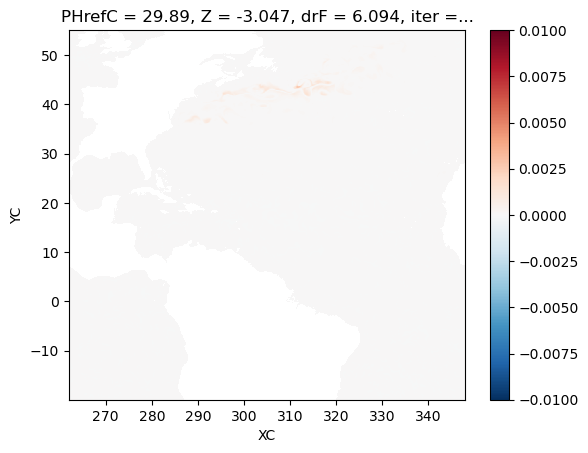

In [17]:
(bp-bp_r).isel(time=0,Z=0,nmemb=0).plot(vmin=-1e-2, vmax=1e-2, cmap='RdBu_r')

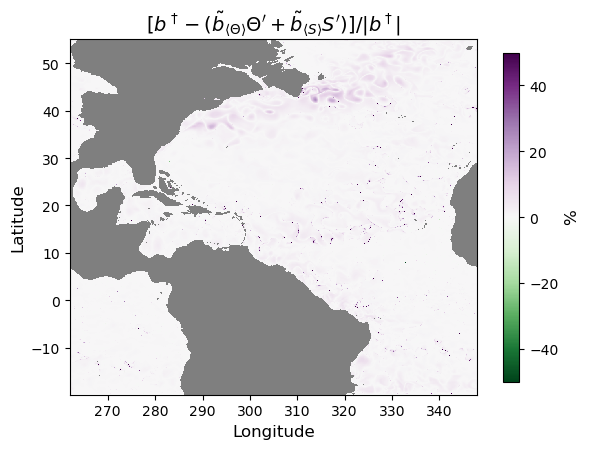

In [10]:
fig, ax = plt.subplots(figsize=(6,5))
fig.set_tight_layout(True)

im = ax.pcolormesh(bp_r.XC, bp_r.YC, 
                   ((bp-bp_r)/np.abs(bp)*1e2).isel(time=0,Z=15,nmemb=0),
                   vmin=-50., vmax=50., cmap='PRGn_r', rasterized=True)
ax.pcolormesh(dsg.XC, dsg.YC, dsg.maskC.where(dsg.maskC!=1.).isel(Z=15),
              vmin=-2, vmax=2, cmap='binary', rasterized=True)

ax.set_title(r"$[b^\dagger - (\tilde{b}_{\langle\Theta\rangle}\Theta'$"
             + r"$+\tilde{b}_{\langle S\rangle}S')]/|b^\dagger|$", 
             fontsize=14)
ax.set_ylabel(r"Latitude", fontsize=12)
ax.set_xlabel(r"Longitude", fontsize=12)
ax.set_aspect('equal')

cbar = fig.colorbar(im, ax=ax, shrink=.7)
cbar.set_label(r"$\%$", fontsize=12)
plt.savefig(op.join(savedir,'Figures/PERDIFF_bp_recon_%010d.pdf' % ntimes[0,0]))

In [11]:
bp.name = 'BUOY'
bp_r.name = 'Reconstruct'

In [12]:
histo = xhist(bp_r, 
              bp,
              bins=[np.concatenate((-np.logspace(-2,-5,15),
                                    np.concatenate((np.linspace(-9e-6,9e-6,11),
                                                    np.logspace(-5,-2,15))))), 
                    np.concatenate((-np.logspace(-2,-5,15),
                                    np.concatenate((np.linspace(-9e-6,9e-6,11),
                                                    np.logspace(-5,-2,15)))))
                   ]
             ).compute()

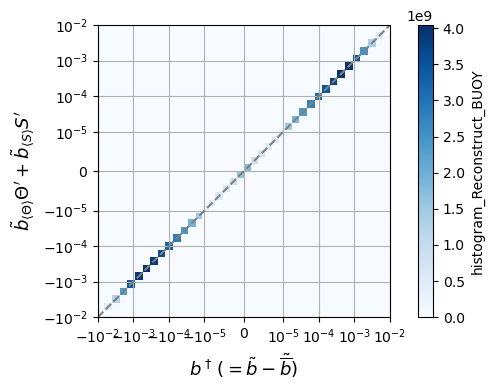

In [13]:
fig, ax = plt.subplots(figsize=(6,4))
fig.set_tight_layout(True)

histo.plot(ax=ax, cmap='Blues')

ax.plot(np.linspace(-1e-2,1e-2), np.linspace(-1e-2,1e-2), c='grey', ls='--')
# ax.plot(np.linspace(-1e-6,-1e-10), np.linspace(1e-6,1e-10), c='grey', ls='--')
ax.set_xscale('symlog', linthresh=1e-5)
ax.set_yscale('symlog', linthresh=1e-5)
ax.set_ylim([-1e-2,1e-2])
ax.set_xlim([-1e-2,1e-2])
ax.set_ylabel(r"$\tilde{b}_{\langle\Theta\rangle}\Theta' + \tilde{b}_{\langle S\rangle}S'$", 
              fontsize=13)
ax.set_xlabel(r"$b^\dagger\, (=\tilde{b}-\tilde{\overline{b}})$", fontsize=13)

ax.grid(True)
ax.set_aspect('equal')

plt.savefig(op.join(savedir,'Figures/Histo_bp_recon_%010d.pdf' % ntimes[0,0]))